In [ ]:
import pandas as pd
import numpy as np
import re
import string
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix, precision_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV

!pip install contractions

import contractions

# for clean_review
nltk.download('punkt')
nltk.download('stopwords')


Open data set

In [ ]:
df = pd.read_csv('drive/MyDrive/imdb-reviews.csv', sep='\t')

test = None

df

Remove extra columns ('url', 'rating') and add a sentiment column. Sentiment = 1 it is a positive review 0 for negative review.

In [ ]:
def remove_cols(df):
  # διώχνω τα άχρηστα δεδομένα πχ. url rating
  df = df.drop(['url'], axis=1)

  # add sentiment col 0 for negative 1 for positive
  df['sentiment'] = np.where(df['rating']>4.0, 1, 0)

  # no more need for col rating
  df = df.drop(['rating'], axis=1)

  return df

df = remove_cols(df)

NameError: ignored

In [ ]:
df

,review,sentiment
0,I thought this was a quiet good movie. It was ...,1
1,Wagon Master is a very unique film amongst Joh...,1
2,This film has to be as near to perfect a film ...,1
3,I gave this 4 stars because it has a lot of in...,0
4,This movie is really genuine and random. It's ...,1
...,...,...
45003,I don't even know where to begin...<br /><br /...,0
45004,One of the worst movies I saw in the 90s. I'd ...,0
45005,Baldwin has really stooped low to make such mo...,0
45006,If you liked watching Mel Gibson in Million Do...,0


If test file exists do the same preprocessing

In [ ]:
if test is not None:
  test = remove_cols(test)
  X_test = test['review']
  Y_test = test['sentiment']

In [ ]:
test

In [ ]:
df.info()

#Preprocessing.

Function to clean review from html tags, numbers, punctuation and stopwords.

In [ ]:
# r tells python that the expression is raw string
def clean_review(review):
  review = review.lower()
  review = re.sub(r'<br />+', '', review)
  review = re.sub(r'(?is)</html>.+', '</html>', review)
  review = re.sub(r'[0-9]+', '', review)  # remove numbers from review

  return review

Expand Contractions


In [ ]:
def expand_contractions(review):
  return contractions.fix(review)

Stemming

In [ ]:
def stemming(review):
  stemmer = PorterStemmer()
  tect = [stemmer.stem(word) for word in review]

  return review

Clean the reviews

In [ ]:
df['review'] = df['review'].apply(lambda x: clean_review(x)) # solo -> 0.8932411740965067
df['review'] = df['review'].apply(lambda x: expand_contractions(x)) # solo -> 0.9000177200188155
df['review'] = df['review'].apply(lambda x: stemming(x))

if test is not None:
  test['review'] = test['review'].apply(lambda x: expand_contractions(x)) # solo -> 0.9000177200188155
  test['review'] = test['review'].apply(lambda x: clean_review(x)) # solo -> 0.8932411740965067
  test['review'] = test['review'].apply(lambda x: stemming(x))

# expand_contractions + stemming # Mean score is  0.9000177200188155
# all 0.8936633321321701 with stop words on clean, 0.896351764316789 without, 0.8951742111845629 without non_sentimental_words
# all without removing punctuations 0.9003509916360969

# df

#Vectorize

In [ ]:
X = df['review']
Y = df['sentiment']

Function to use TfidVectorizer

In [ ]:
def use_TfidVectorizer(X,Y):
  vect = TfidfVectorizer()
  X = vect.fit_transform(df['review'])

  x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

  model = LogisticRegression(penalty="l2", solver="newton-cg", C=0.1)
  model.fit(x_train, y_train)

  prediction = model.predict(x_test)
  accuracy = accuracy_score(prediction, y_test)
  print("Accuracy : ", accuracy)

  return model, x_train, y_train

Function to use CountVectorizer

In [ ]:
def use_CrossVal_CountVectorizer(X,Y):
  kfold = KFold(n_splits=5, random_state=42, shuffle=True)

  vector = CountVectorizer().fit(X)
  vector.get_feature_names_out()

  X_train_vectorized = vector.transform(X)

  model = LogisticRegression(penalty="l2", solver="newton-cg", C=0.1)
  model.fit(X_train_vectorized, Y)
  avg = cross_val_score(model, X_train_vectorized, Y, cv=kfold)

  print("Mean score is ", np.mean(avg))
  print("scores are ", avg)

  return model, X, Y

In [ ]:
#model,x_train, y_train = use_TfidVectorizer(X,Y)

#Accuracy :  0.8746945123305933

In [ ]:

if test is None:
  model, x_train, y_train = use_CrossVal_CountVectorizer(X,Y)

#Mean score is  0.9003509916360969

Mean score is  0.9003509891677839
scores are  [0.9034659  0.89891135 0.90135525 0.89878902 0.89923342]


In [ ]:
# X, Y are the trainig data and
def use_CountVectorizer(X, Y, X_test, Y_test):
  # training
  X_train = X
  Y_train = Y

  vector = CountVectorizer().fit(X_train)
  vector.get_feature_names_out()

  X_train_vectorized = vector.transform(X_train)

  model = LogisticRegression(penalty="l2", solver="newton-cg", C=0.1)
  model.fit(X_train_vectorized, Y_train)

  # Validation
  predictions_train = model.predict(X_train_vectorized) # results train
  predictions_test = model.predict(vector.transform(X_test))

  f1_train = f1_score(Y_train, predictions_train)
  f1_val = f1_score(Y_test, predictions_test)

  precision_train = precision_score(Y_train, predictions_train)
  precision_val = precision_score(Y_test, predictions_test)

  recall_train = recall_score(Y_train, predictions_train)
  recall_val = recall_score(Y_test, predictions_test)

  print("F1 Score (train): ", f1_train)
  print("F1 Score (validation): ", f1_val)
  print("Precision Score (train): ", precision_train)
  print("Precision Score (validation): ", precision_val)
  print("Recall Score (train): ", recall_train)
  print("Recall Score (validation): ", recall_val)


In [ ]:
if test is not None:
 use_CountVectorizer(X, Y, X_test, Y_test)

#Plot

In [ ]:
def plot():
  list_f1 = []
  list_f1_train = []
  list_sample_size = []

  for times in range(10):
    # training
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size= 1 - (times * 0.1 + 0.001))

    vector = CountVectorizer().fit(X_train)
    vector.get_feature_names_out()

    X_train_vectorized = vector.transform(X_train)

    model = LogisticRegression(penalty="l2", solver="newton-cg", C=0.1)
    model.fit(X_train_vectorized, Y_train)

    # Validation
    predictions_train = model.predict(X_train_vectorized) # results train
    predictions_test = model.predict(vector.transform(X_test))

    # Score
    f1_train = f1_score(Y_train, predictions_train)
    f1_val = f1_score(Y_test, predictions_test)

    precision_train = precision_score(Y_train, predictions_train)
    precision_val = precision_score(Y_test, predictions_test)

    recall_train = recall_score(Y_train, predictions_train)
    recall_val = recall_score(Y_test, predictions_test)

    print(times)
    print("F1 Score (train): ", f1_train)
    print("F1 Score (validation): ", f1_val)
    print("Precision Score (train): ", precision_train)
    print("Precision Score (validation): ", precision_val)
    print("Recall Score (train): ", recall_train)
    print("Recall Score (validation): ", recall_val)
    print()

    list_f1.append(f1_val)
    list_f1_train.append(f1_train)
    list_sample_size.append((times * 0.1 + 0.1))

  plt.plot(list_sample_size, list_f1)
  plt.plot(list_sample_size, list_f1_train)

  plt.ylim(ymin=0)
  plt.legend(["Validation", "Training"])

0
F1 Score (train):  1.0
F1 Score (validation):  0.6403126285479227
Precision Score (train):  1.0
Precision Score (validation):  0.5955997704228047
Recall Score (train):  1.0
Recall Score (validation):  0.6922837447187014

1
F1 Score (train):  0.9916958041958042
F1 Score (validation):  0.859789329618496
Precision Score (train):  0.9916958041958042
Precision Score (validation):  0.8498816253563318
Recall Score (train):  0.9916958041958042
Recall Score (validation):  0.8699307616221563

2
F1 Score (train):  0.9886651260041818
F1 Score (validation):  0.8742660906170377
Precision Score (train):  0.9863855950812472
Precision Score (validation):  0.8704571775216456
Recall Score (train):  0.9909552172953894
Recall Score (validation):  0.8781084840055633

3
F1 Score (train):  0.9817941565115255
F1 Score (validation):  0.8870054710477214
Precision Score (train):  0.9809300278714977
Precision Score (validation):  0.8810152029149391
Recall Score (train):  0.9826598089639971
Recall Score (validati

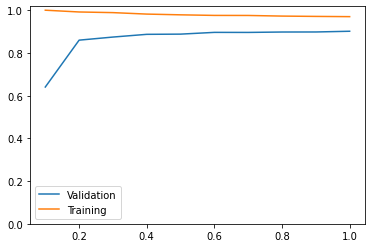

In [ ]:
plot()